In [1]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%tensorflow_version 2.x 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import json
from glob import glob
from PIL import Image
import pickle
import keras
import warnings

import sys, time, os, warnings 

from tqdm import tqdm

from collections import Counter 
from nltk.translate.bleu_score import sentence_bleu

import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!unzip Images.zip

In [5]:
import os
os.chdir('/content/drive/MyDrive/DLProject')

In [6]:
images_path = '/content/drive/MyDrive/DLProject/Images/'
captions_path = '/content/drive/MyDrive/DLProject/Flickr8k.token.txt'

total_images = os.listdir(images_path)
print("Total Number of images: {}".format(len(total_images)))

Total Number of images: 9370


In [7]:
file = open(captions_path, 'r')
text = file.read()
file.close()

rows = text.split('\n')
data = []
for row in rows:
    if row:
        file_caption = row.split('\t')
        if len(file_caption) == 1:
          continue
        filename_index = file_caption[0]
        index_list = filename_index.split('#')
        data.append((index_list[0], index_list[1], file_caption[1]))

images_data = pd.DataFrame(data, columns=['filename', 'index', 'captions'])
print(images_data.head())

unique_files = np.unique(images_data.filename.values)
print("Total images : {}".format(len(unique_files)))
Counter(Counter(images_data.filename.values).values())

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                            captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Total images : 8091


Counter({5: 8091})

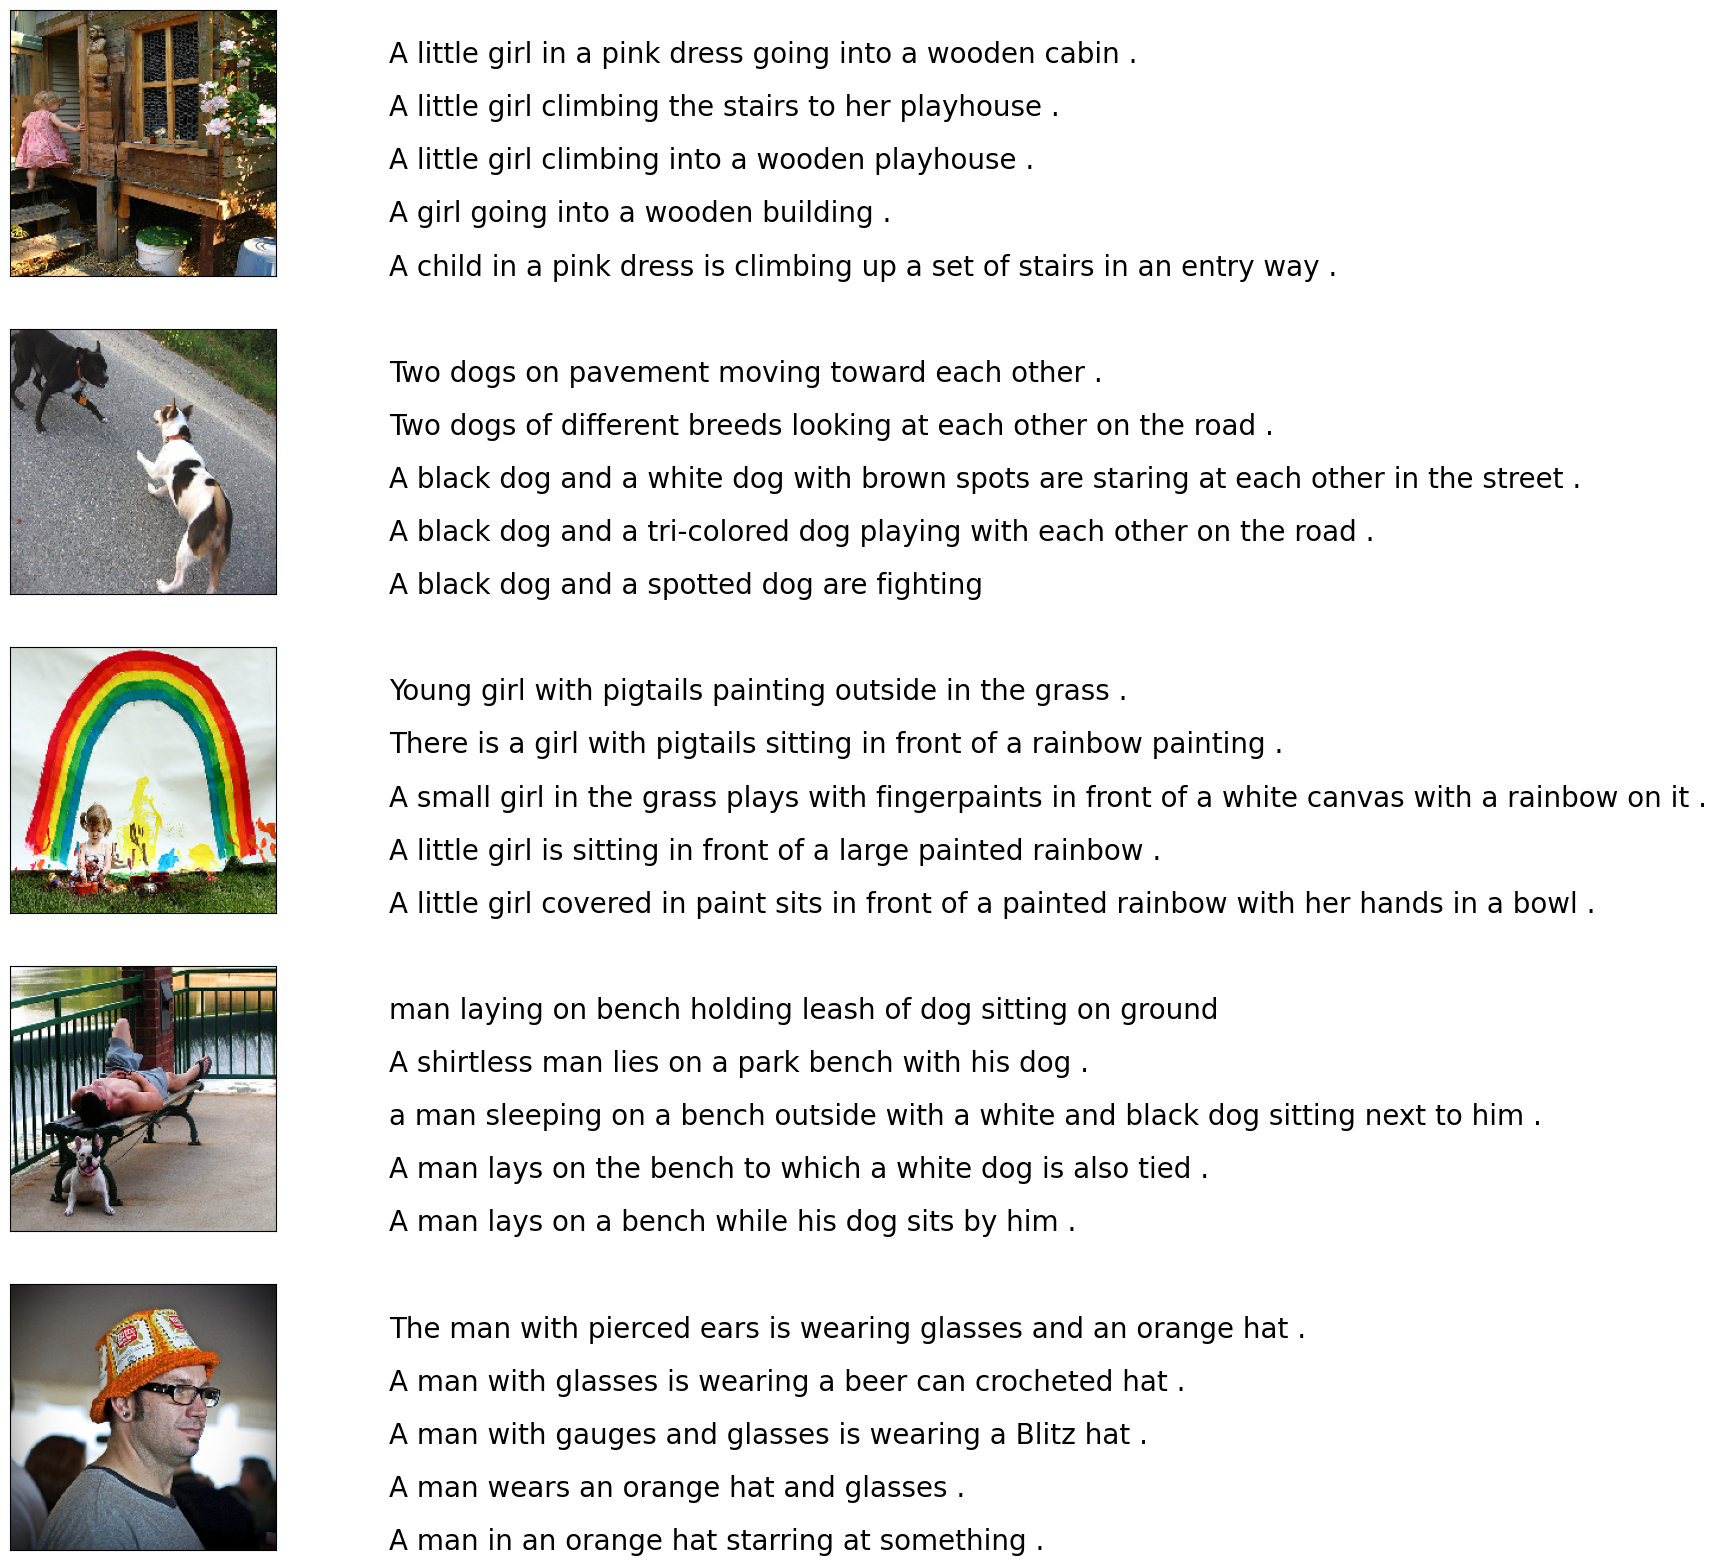

In [8]:
pic = 5
pixel = 224
target_size = (pixel,pixel,3)

count = 1
fig = plt.figure(figsize=(10,20))
for fl in unique_files[:pic]:
    filename = images_path + '/' + fl
    captions = list(images_data["captions"].loc[images_data["filename"]==fl].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(pic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(pic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [9]:
def vocabulary(df_txt):
  vocab = []
  for txt in df_txt.captions.values:
    vocab.extend(txt.split())
  print('Total words in vocabulary: %d' % len(set(vocab)))
  ct = Counter(vocab)
  word_data = pd.DataFrame.from_dict(ct, orient='index').sort_values(by=0, ascending=False)
  word_data = word_data.reset_index()
  word_data = word_data.rename({'index':'word',0:'count'}, axis=1)
  return(word_data)

word_data = vocabulary(images_data)
word_data.head()

Total words in vocabulary: 9630


,word,count
0,a,40319
1,.,36577
2,A,22667
3,in,18962
4,the,15328


In [10]:
images = images_data['filename'].tolist()
captions = images_data['captions'].tolist()

img_list = list()
for name in images:
  full_path = images_path + name
  img_list.append(full_path)

cap_list = list()
for caption in captions:
  new_caption = '<start> ' + caption + ' <end>'
  cap_list.append(new_caption)

train_captions_, img_vector_ = shuffle(cap_list,
                                          img_list,
                                          random_state=1)


num_examples = 35900
train_captions = train_captions_[:num_examples]
img_name_vector = img_vector_[:num_examples]

print("img_name_vector", img_name_vector[:10])
print("train_captions", train_captions[:10])

test_captions = train_captions_[num_examples:]
fnm_test = img_vector_[num_examples:]

print("Training with ",len(train_captions), "captions in total of:", len(cap_list))

img_name_vector ['/content/drive/MyDrive/DLProject/Images/1956678973_223cb1b847.jpg', '/content/drive/MyDrive/DLProject/Images/3256603992_67312b5a36.jpg', '/content/drive/MyDrive/DLProject/Images/2938747424_64e64784f0.jpg', '/content/drive/MyDrive/DLProject/Images/2831314869_5025300133.jpg', '/content/drive/MyDrive/DLProject/Images/516725192_c9cdd63878.jpg', '/content/drive/MyDrive/DLProject/Images/537559285_29be110134.jpg', '/content/drive/MyDrive/DLProject/Images/2172493537_128bc8b187.jpg', '/content/drive/MyDrive/DLProject/Images/2287023569_fd7a9c60b8.jpg', '/content/drive/MyDrive/DLProject/Images/3191805046_77c334b506.jpg', '/content/drive/MyDrive/DLProject/Images/2869491449_1041485a6b.jpg']
train_captions ['<start> Several children leaping into a pile of leaves on the ground . <end>', '<start> A man hiking in the wilderness giving the camera a thumbs up . <end>', '<start> A white dog is running through the water onto the shore . <end>', '<start> a young man relaxing his legs on a 

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    image_path += '/'
    return img, image_path

In [12]:
cnn = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = cnn.input
hidden_layer = cnn.layers[-1].output

feature_extractor = tf.keras.Model(new_input, hidden_layer)

feature_extractor.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = feature_extractor(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    base_path, ext = path_of_feature.split('.')
    np.save(base_path, bf.numpy())

  0%|          | 2/506 [02:02<9:41:03, 69.17s/it]

In [ ]:
def maximum_length(tensor):
    return max(len(t) for t in tensor)
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
sequences = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
sequences = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

max_length = maximum_length(sequences)

In [ ]:
train_data, val_data, train_captions, val_captions = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

len(train_data), len(train_captions), len(val_data), len(val_captions)

In [ ]:
def load_numpy(img_name, cap):
  base_path = img_name.decode('utf-8').split(".")
  img_tensor = np.load(base_path[0]+'.npy')
  return img_tensor, cap

bs = 64
buffer = 1000
dimension = 256
units = 512
vocab_size = top_k + 1
num_steps = len(train_data) // bs

features_shape = 2048
attention_features_shape = 64

ds = tf.data.Dataset.from_tensor_slices((train_data, train_captions))

ds = ds.map(lambda item1, item2: tf.numpy_function(
          load_numpy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds = ds.shuffle(buffer).batch(bs)
ds = ds.prefetch(buffer=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_captions))

val_ds = val_ds.map(lambda item1, item2: tf.numpy_function(
          load_numpy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
class SoftAttention(tf.keras.Model):
  def __init__(self, units):
    super(SoftAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, dimension):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(dimension)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, dimension, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, dimension)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = SoftAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, bs):
    return tf.zeros((bs, self.units))

In [ ]:
encoder = CNN_Encoder(dimension)
decoder = RNN_Decoder(dimension, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
check = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
start_epoch = 0
manage_checkpoint = tf.train.CheckpointManager(check, checkpoint_path, max_to_keep=5)
if manage_checkpoint.latest_checkpoint:
  start_epoch = int(manage_checkpoint.latest_checkpoint.split('-')[-1])
  check.restore(manage_checkpoint.latest_checkpoint)

In [ ]:
@tf.function
def training(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])

  d_ip = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(d_ip, features, hidden)

          loss += loss_function(target[:, i], predictions)

          d_ip = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
loss_plot = []
val_loss_plot = []
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(ds):
        batch_loss, t_loss = training(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_ds):
        val_batch_loss, val_t_loss = training(img_tensor, target)
        val_total_loss += val_t_loss
        if batch % 100 == 0:
            print('Val_Loss {:.4f}'.format(val_batch_loss.numpy() / int(target.shape[1]))
    val_loss_plot.append(val_total_loss / num_steps)

    if epoch % 5 == 0:
      manage_checkpoint.save()

    print ('Epoch {} Loss {:.6f} Val_Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
plt.plot(loss_plot, color='red')
plt.plot(val_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extractor(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
rid = np.random.randint(0, len(val_data))
image = val_data[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
real_captions = []
generated_captions = []
img_path = []

n_tests = 300

for i,image in enumerate(val_data[:n_tests]):
  real_captions.append(' '.join([tokenizer.index_word[i] for i in val_captions[i] if i not in [0]]))
  caption, attention_plot = evaluate(image)
  img_path.append(image)
  generated_captions.append(caption)
  if i % 100 == 0: print("Describing id %d" %(i)) 

In [ ]:
warnings.filterwarnings('ignore')
tokenized_real_captions = []
tokenized_generated_captions = []
for caption in generated_captions:
  d_caption = caption[:len(caption)-1]
  tokenized_generated_captions.append(d_caption)

for caption in real_captions:
  back_caption = caption
  back_caption = back_caption.split()
  back_caption = back_caption[1:-1]
  tokenized_real_captions.append(back_caption)

pred_good, pred_bad, bleus, meteors = [], [], [], []
for i, path in enumerate(img_path):
  caption_true = tokenized_real_captions[i]
  gen_caption = tokenized_generated_captions[i]
  bleu = sentence_bleu([caption_true], gen_caption)
  bleus.append(bleu)
  if bleu > 0.7:
    pred_good.append((bleu,path,caption_true,gen_caption))
  elif bleu < 0.3:
    pred_bad.append((bleu,path,caption_true,gen_caption))

sns.set(color_codes = True)
sns.distplot(bleus)

print("\t\t\t BLEU")
print("BLEU higher: ", np.amax(bleus))
print("BLEU lower: ", np.amin(bleus))
print("Mean BLEU Score {:4.3f}".format(np.mean(bleus)))

In [ ]:
def plot_images(generated_captions):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(generated_captions)
    for pb in generated_captions:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"real:" + caption_true,fontsize=20)
        ax.text(0,0.4,"generada:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Descripciones malas")
plot_images(pred_bad[:5])
print("Descripciones buenas")
plot_images(pred_good[:5])

Base Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, GRU, Dropout

@tf.function
def base_model(img_tensor, target):
    # Define CNN (Inception V3) model
    cnn_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True), input_shape=dimension)

    # Define RNN (GRU) model
    rnn_model = tf.keras.Sequential([
        GRU(256, return_sequences=True, input_shape=(None, 2048)),
        Dropout(0.5),
        GRU(128),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(vocab_size, activation='softmax')
    ])

    # Combine CNN and RNN models

    #model = tf.keras.Model(inputs=input_tensor, outputs=rnn_output)

    with tf.GradientTape() as tape:
          input_tensor = Input(shape=dimension)
          cnn_output = cnn_model(input_tensor)
          for i in range(1, target.shape[1]):
            rnn_output = rnn_model(cnn_output)


    # Compile the model
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')


In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    for (batch, (img_tensor, target)) in enumerate(ds):
        base_model(img_tensor, target)

    if epoch % 5 == 0:
      manage_checkpoint.save()

    print ('Epoch {}'.format(epoch + 1))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
def evaluate(image):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = cnn_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = cnn_model(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = rnn_model(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
real_captions = []
generated_captions = []
img_path = []

n_tests = 300

for i,image in enumerate(val_data[:n_tests]):
  real_captions.append(' '.join([tokenizer.index_word[i] for i in val_captions[i] if i not in [0]]))
  caption, attention_plot = evaluate(image)
  img_path.append(image)
  generated_captions.append(caption)
  if i % 100 == 0: print("Describing id %d" %(i)) 

In [ ]:
warnings.filterwarnings('ignore')
tokenized_real_captions = []
tokenized_generated_captions = []
for caption in generated_captions:
  d_caption = caption[:len(caption)-1]
  tokenized_generated_captions.append(d_caption)

for caption in real_captions:
  back_caption = caption
  back_caption = back_caption.split()
  back_caption = back_caption[1:-1]
  tokenized_real_captions.append(back_caption)

pred_good, pred_bad, bleus, meteors = [], [], [], []
for i, path in enumerate(img_path):
  caption_true = tokenized_real_captions[i]
  gen_caption = tokenized_generated_captions[i]
  bleu = sentence_bleu([caption_true], gen_caption)
  bleus.append(bleu)
  if bleu > 0.7:
    pred_good.append((bleu,path,caption_true,gen_caption))
  elif bleu < 0.3:
    pred_bad.append((bleu,path,caption_true,gen_caption))

sns.set(color_codes = True)
sns.distplot(bleus)

print("\t\t\t BLEU")
print("BLEU higher: ", np.amax(bleus))
print("BLEU lower: ", np.amin(bleus))
print("Mean BLEU Score {:4.3f}".format(np.mean(bleus)))